[Local Guide File Path](/home/carles/Documents/MIRI/FRR/PDF/GuideLine3.pdf).

### cube map that stores diffuse irradiance
INPUT: Six separated images that represent a cube map.

In [ ]:
%pip install pillow
%pip install matplotlib
%pip install ipympl

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
# %matplotlib widget
# %matplotlib inline 


In [32]:
###### Interactive plots? ######
interactive = True
if interactive:
    %matplotlib widget
else:
    %matplotlib inline 
    

In [244]:
class CubeMap():
    def __init__(self) -> None:
        self.resolution = (0,0,0)
        self.cube_map = {
            'back':None, 
            'front':None, 
            'left':None, 
            'right':None, 
            'top':None, 
            'bottom':None}
        self.cube_map_diffuse = {
            'back':None, 
            'front':None, 
            'left':None, 
            'right':None, 
            'top':None, 
            'bottom':None}
        self.id_tag = {
            0:"right",
            1:"left",
            3:"back",
            2:"front",
            4:"top",
            5:"bottom",
            "right"  :0,
            "left"   :1,
            "back"   :2,
            "front"  :3,
            "top"    :4,
            "bottom" :5,}
        self.face_index=np.array([])

    def _generate_cubemap_diffuse(self):
        black_image = np.zeros(self.resolution,dtype=np.float32)
        for i in self.cube_map_diffuse.keys():
            self.cube_map_diffuse[i]=black_image

    def load_cubemap(self, folder_path):
        # Define the expected image file names
        image_names = ['back', 'front', 'left', 'right', 'top', 'bottom']

        # Iterate through the image names
        for name in image_names:
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, f"{name}.png")  # Adjust the file extension as needed

            # Check if the file exists
            if os.path.exists(image_path):
                # Load the image using Pillow
                image = Image.open(image_path)
                image = np.array(image,dtype=np.float32)/255 
                image = np.rot90(image[:,:,:3],k=1)
                if name in ["top","bottom"]:
                    image = np.rot90(image[:,:,:3],k=2)

                # Add the image to the cube_map dictionary
                self.cube_map[name] = image
            else:
                print(f"Image file '{name}.png' not found in the folder.")
        self.resolution = image.shape
        self.prepare_cubemap()
        
    def prepare_cubemap(self):
        self.cube_map["top"]=np.flip(np.rot90(self.cube_map["top"][:,:,:3], k=3),axis=(1))
        self.cube_map["left"]=np.flip(np.rot90(self.cube_map["left"][:,:,:3], k=3),axis=(1))
        self.cube_map["front"]=np.flip(np.rot90(self.cube_map["front"][:,:,:3], k=3),axis=(1))
        self.cube_map["right"]=np.flip(np.rot90(self.cube_map["right"][:,:,:3], k=3),axis=(1))
        self.cube_map["back"]=np.flip(np.rot90(self.cube_map["back"][:,:,:3], k=3),axis=(1))
        self.cube_map["bottom"]=np.flip(np.rot90(self.cube_map["bottom"][:,:,:3], k=3),axis=(1))

    def plot(self,images=None):
        if images==None:
            images = self.cube_map
        # Generate big image:
        fil,col=self.resolution[:2]
        image = np.zeros((col*3, fil*4, 3), dtype=np.float32)

        image[0:fil, col:col*2]=images["top"][:,:,:3]
        image[fil:fil*2, 0:col]=images["left"][:,:,:3]
        image[fil:fil*2, col:col*2]=images["front"][:,:,:3]
        image[fil:fil*2, col*2:col*3]=images["right"][:,:,:3]
        image[fil:fil*2, col*3:col*4]=images["back"][:,:,:3]
        image[fil*2:fil*3, col:col*2]=images["bottom"][:,:,:3]

        # Create a new figure
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image)
        plt.show()

    def prepare_face_index(self,cubized_vector):
        self.face_index = self.cube_face_list(cubized_vector)

    def cubized_vector_to_pixel(self, cubized_vector):
        PixelID = np.zeros((2,len(self.face_index)))

        PixelID[:,self.face_index==0] = ((np.array([ -cubized_vector[2,self.face_index==0], -cubized_vector[1,self.face_index==0]])+1)/2)
        PixelID[:,self.face_index==1] = ((np.array([ -cubized_vector[2,self.face_index==1],  cubized_vector[1,self.face_index==1]])+1)/2)
        PixelID[:,self.face_index==2] = ((np.array([ -cubized_vector[2,self.face_index==2],  cubized_vector[0,self.face_index==2]])+1)/2)
        PixelID[:,self.face_index==3] = ((np.array([ -cubized_vector[2,self.face_index==3], -cubized_vector[0,self.face_index==3]])+1)/2)
        PixelID[:,self.face_index==4] = ((np.array([  cubized_vector[1,self.face_index==4],  cubized_vector[0,self.face_index==4]])+1)/2)
        PixelID[:,self.face_index==5] = ((np.array([ -cubized_vector[1,self.face_index==5],  cubized_vector[0,self.face_index==5]])+1)/2)

        PixelID=(PixelID * self.resolution[0]).astype(np.int32) # image resolution size
        return PixelID
    
    def pixel_to_color(self,PixelID):
        Colors = np.zeros((3,len(self.face_index)))
        for i in range(6):
            Colors[:,self.face_index==i] =  self.cube_map[self.id_tag[i]][PixelID[0,self.face_index==i],PixelID[1,self.face_index==i]].T
        return Colors
    
    def cube_face_list(self,u):
        """u = list of cubized vectors"""
        abs_u = np.abs(u)
        max_index = np.argmax(abs_u,0)
        max_value = u[max_index, np.arange(u.shape[1])]
        face_index = max_index * 2 + (max_value < 0)
        return face_index
     
    def _normal_to_pixel(self,normal):
        # DEBUG:DEPRECATED
        # Normalize the normal vector
        normal /= np.linalg.norm(normal)

        # Determine which face of the cube the normal intersects
        abs_normal = np.abs(normal)
        max_index = np.argmax(abs_normal)
        face_index = max_index * 2 + (normal[max_index] < 0)
        
        # Map the normalized normal vector onto the 2D texture coordinates of the chosen face
        u, v = 0, 0
        if face_index == 0:    # +X
            if abs_normal[0] != 0:
                u = 1-(normal[2] / abs_normal[0] * 0.5 + 0.5)
                v = normal[1] / abs_normal[0] * 0.5 + 0.5
        elif face_index == 1:  # -X
            if abs_normal[0] != 0:
                u = 1-(normal[2] / abs_normal[0] * 0.5 + 0.5)
                v = 1-(normal[1] / abs_normal[0] * 0.5 + 0.5)
        elif face_index == 2:  # +Y
            if abs_normal[1] != 0:
                u = (normal[0] / abs_normal[1] * 0.5 + 0.5)
                v = (normal[2] / abs_normal[1] * 0.5 + 0.5)
        elif face_index == 3:  # -Y
            if abs_normal[1] != 0:
                u = 1-(normal[0] / abs_normal[1] * 0.5 + 0.5)
                v = (normal[2] / abs_normal[1] * 0.5 + 0.5)
        elif face_index == 4:  # +Z
            if abs_normal[1] != 0:
                u = 1-(normal[0] / abs_normal[2] * 0.5 + 0.5)
                v = (normal[1] / abs_normal[2] * 0.5 + 0.5)
        elif face_index == 5:  # -Z
            if abs_normal[2] != 0:
                u = 1-(normal[0] / abs_normal[2] * 0.5 + 0.5)
                v = 1-(normal[1] / abs_normal[2] * 0.5 + 0.5)
        
        # Map the texture coordinates to pixel coordinates within the image
        image_width, image_height = self.resolution[:2]  # Assuming all images have the same size
        pixel_u = int(u * (image_width))
        pixel_v = int(v * (image_height))

        # Return the pixel coordinates and the image
        return pixel_u, pixel_v, face_index

    def _pixel_to_normal(self, x, y, face):
        u = (2 * x + 1) / self.resolution[0] - 1
        v = (2 * y + 1) / self.resolution[0] - 1
        if face == 0:  # +X face
            u= np.array([1, v, -u])
        elif face == 1:  # -X face
            u= np.array([-1, -v, -u])
        elif face == 2:  # +Y face
            u= np.array([u, 1, v])
        elif face == 3:  # -Y face
            u= np.array([-u, -1, v])
        elif face == 4:  # +Z face
            u= np.array([-u, v, 1])
        elif face == 5:  # -Z face
            u= np.array([-u, -v, -1])
        return u/np.linalg.norm(u)

    def _get_color(self,x:int,y:int,f:int):
        f = self.id_tag[f]
        color = self.cube_map[f][x,y]
        return color[:3]

    def _normals_to_cube(self, normals):
        for n in normals:
            print(self._normal_to_pixel(n))

    def _get_tag(self,id):
        return self.id_tag[id]

    def _rotation_matrix_from_vectors(self, vec1, vec2):
        # Ensure the vectors are normalized
        vec1 = vec1 / np.linalg.norm(vec1)
        vec2 = vec2 / np.linalg.norm(vec2)

        # Calculate the cross product and dot product
        cross = np.cross(vec1, vec2)
        dot = np.dot(vec1, vec2)

        # Calculate the skew-symmetric cross product matrix
        skew_cross = np.array([[0, -cross[2], cross[1]],
                            [cross[2], 0, -cross[0]],
                            [-cross[1], cross[0], 0]])

        # Calculate the rotation matrix
        rotation_matrix = np.eye(3) + skew_cross + np.dot(skew_cross, skew_cross) * (1 / (1 + dot))

        return rotation_matrix
    
    def _random_radiance_normal(self, u, N=50):

        R = np.random.randn(N, 3)
        R[:, 2] = np.abs(R[:, 2])
        R = R / np.sqrt(np.sum(R**2, axis=1, keepdims=True))

        # Define the normal direction u
        u = u / np.linalg.norm(u)  # Ensure u is normalized
        up = np.array([0.001, 0.001, 1])
        up =  up / np.linalg.norm(up) 

        # Calculate rotation matrix to align points with the normal direction u
        rotation_matrix = self._rotation_matrix_from_vectors(up, u)

        # Rotate the points
        R_rotated = np.dot(R, rotation_matrix.T).T 
        return R_rotated
    
    def generate_similar_vectors(self,normal_vector, n_vectors, max_angle_degrees):
        def random_vector_in_cone(cone_angle, num_samples=100):
            """
            Generate random vectors within a cone defined by the cone_angle.
            cone_angle should be in radians.
            """
            # Generate random azimuthal angles
            azimuthal_angles = np.random.uniform(0, 2*np.pi, num_samples)
            
            # Generate random zenith angles within the cone angle
            zenith_angles = np.arccos(np.random.uniform(np.cos(cone_angle), 1, num_samples))
            
            # Convert spherical coordinates to Cartesian coordinates
            x = np.sin(zenith_angles) * np.cos(azimuthal_angles)
            y = np.sin(zenith_angles) * np.sin(azimuthal_angles)
            z = np.cos(zenith_angles)
            
            return np.vstack((x, y, z))
        random_vectors=random_vector_in_cone(np.deg2rad(max_angle_degrees),n_vectors)
        rotation_matrix = self._rotation_matrix_from_vectors(np.array([0.001,0.001,1]),normal_vector)
        R_rotated = np.dot(random_vectors.T, rotation_matrix.T).T
        return R_rotated

    def plot_normal(self, vector, red_vector=[0,0,0]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # for v in vector:
        ax.quiver(0, 0, 0, vector[0],vector[1],vector[2],arrow_length_ratio=0)
        
        # for u in red_vector:
        ax.quiver(0, 0, 0, *red_vector, color=(1,0,0))

        # draw cube
        r = [-1,1]
        X, Y = np.meshgrid(r, r)
        X=np.array(X,dtype=np.float32)*.5
        Y=np.array(Y,dtype=np.float32)*.5
        Z = np.array([[1.,1.],[1.,1.]])*.5
        ax.plot_surface(X,Y,Z, alpha=0.5)
        ax.plot_surface(X,Y,-Z, alpha=0.5)
        ax.plot_surface(X,-Z,Y, alpha=0.5)
        ax.plot_surface(X,Z,Y, alpha=0.5)
        ax.plot_surface(Z,X,Y, alpha=0.5)
        ax.plot_surface(-Z,X,Y, alpha=0.5)

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_surface(x, y, z, color=(.2,.0,.8,.2))
        
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_aspect("equal")
        
        plt.show()

    def spherical_to_cartesian(self, spherical_coords, cube_length=False):
        """
        Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z).
        """
        def adjust_vector_length(x, y, z, cube_size):
            # Check if the vector intersects any of the cube's faces
            mask_x = np.abs(x) > cube_size / 2
            mask_y = np.abs(y) > cube_size / 2
            mask_z = np.abs(z) > cube_size / 2

            # Adjust length to ensure it remains within the cube
            factor_x = np.where(mask_x, (cube_size / 2) / np.abs(x), 1)
            factor_y = np.where(mask_y, (cube_size / 2) / np.abs(y), 1)
            factor_z = np.where(mask_z, (cube_size / 2) / np.abs(z), 1)

            x *= factor_x
            y *= factor_y
            z *= factor_z

            return x, y, z
        
        theta = np.deg2rad(spherical_coords[0])  # Convert theta to radians
        phi = np.deg2rad(spherical_coords[1])    # Convert phi to radians
        
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        if cube_length: x, y, z = adjust_vector_length(x, y, z, 1)
        return np.stack((x, y, z))


## 1.
### We first load the cube map images

In [245]:
cubemap_instance = CubeMap()
cubemap_instance.load_cubemap("./test_images")

### We check the result of the cube

This will look correct if the images used for the cube are on the same oriantation as the ones used by opengl. Make sure they look correct on opengl cubemap before importing them to the python program.

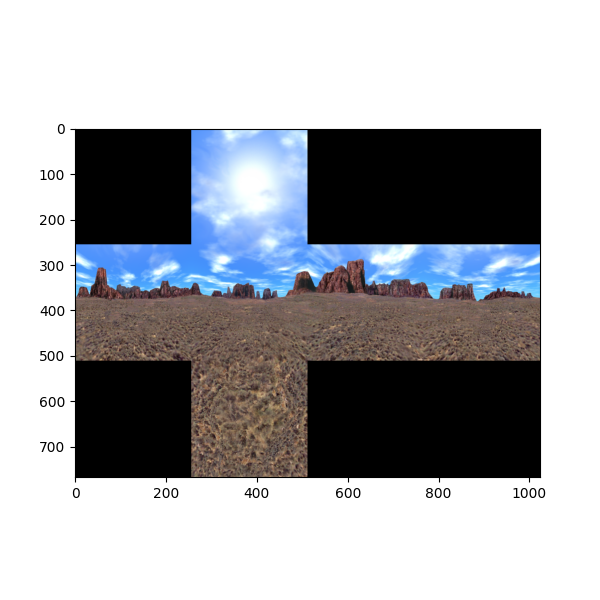

In [236]:
cubemap_instance.plot()

### 2. Generating Vectors
The vectors will be generated on spherical coordinates and passd to cartesian

In [13]:
def spherical_to_cartesian(spherical_coords, cube_length=False):
    """
    Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z).
    """
    def adjust_vector_length(x, y, z, cube_size):
        # Check if the vector intersects any of the cube's faces
        mask_x = np.abs(x) > cube_size / 2
        mask_y = np.abs(y) > cube_size / 2
        mask_z = np.abs(z) > cube_size / 2

        # Adjust length to ensure it remains within the cube
        factor_x = np.where(mask_x, (cube_size / 2) / np.abs(x), 1)
        factor_y = np.where(mask_y, (cube_size / 2) / np.abs(y), 1)
        factor_z = np.where(mask_z, (cube_size / 2) / np.abs(z), 1)

        x *= factor_x
        y *= factor_y
        z *= factor_z

        return x, y, z
    
    theta = np.deg2rad(spherical_coords[0])  # Convert theta to radians
    phi = np.deg2rad(spherical_coords[1])    # Convert phi to radians
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    if cube_length: x, y, z = adjust_vector_length(x, y, z, 1)
    return np.stack((x, y, z))

# Generate a list of spherical coordinates (theta, phi)
num_points = 5
phi = np.random.uniform(0, 360, num_points)  # Random phi values in degrees
theta = np.random.uniform(0, 180, num_points)   # Random theta values in degrees

# Convert spherical coordinates to Cartesian coordinates
cartesian_coords = cubemap_instance.spherical_to_cartesian((theta,phi))

print("Spherical coordinates:")
print(np.array([theta,phi]))
print("\nCartesian coordinates:")
print(cartesian_coords)


Spherical coordinates:
[[ 21.17591632  41.90727108  87.40698686  80.17039772   3.56855179]
 [232.54745739 280.82725499 138.06942031 176.00537668  23.18588712]]

Cartesian coordinates:
[[-0.21966705  0.12546912 -0.74319327 -0.98292608  0.05721552]
 [-0.28676717 -0.65603657  0.66754551  0.0686402   0.02450592]
 [ 0.93247572  0.74422679  0.04524117  0.17071859  0.99806104]]


### 2.1 Plot of random vectors towards +x face


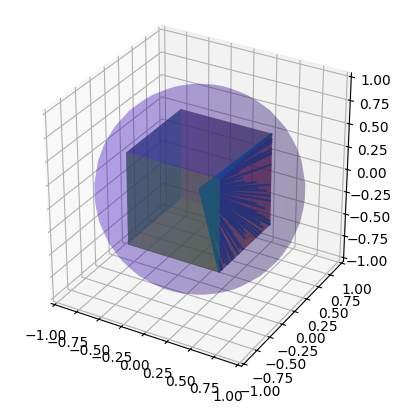

In [14]:
num_points = 100
phi = np.random.uniform(-45, 45, num_points)  # Random phi values in degrees
theta = np.random.uniform(45, 135, num_points)   # Random theta values in degrees

# Convert spherical coordinates to Cartesian coordinates
cartesian_coords = cubemap_instance.spherical_to_cartesian((theta,phi),True)
cubemap_instance.plot_normal(cartesian_coords)

### 2.2 Plot vectors similar to vector u based on angle size

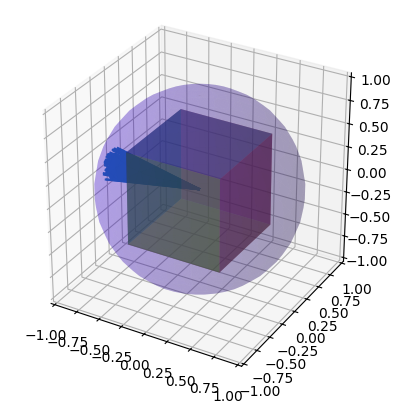

In [15]:
R_rotated = cubemap_instance.generate_similar_vectors(np.array([-1,0,0]),100,10)
cubemap_instance.plot_normal(R_rotated)


### 2.3 Plot 90 degrees on a u vector

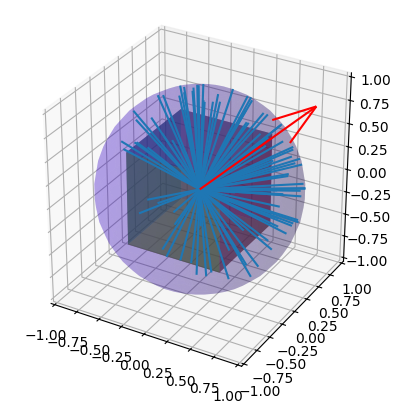

In [16]:

normal_list=cubemap_instance._random_radiance_normal(np.array([1,0,1]),100)
cubemap_instance.plot_normal(normal_list,np.array([1,0,1])*1.2)


### 3 Project sphere on cube
### 3.1 Method
    I recomend using the fast method. Both methods are the same but the fast one is harder to understand. 

In [17]:
def cubize_points_fast(positions):
    cubized_positions = np.zeros_like(positions)
    x, y, z = positions.copy()
    _x, _y, _z = positions.copy()

    fx = np.abs(x)
    fy = np.abs(y)
    fz = np.abs(z)

    inverse_sqrt2 = 0.70710676908493042

    mask_fy = (fy >= fx) & (fy >= fz)
    mask_fx = (fx >= fy) & (fx >= fz)
    mask_fz = ~(mask_fy | mask_fx)

    # y
    a2_fy = x[mask_fy] * x[mask_fy] * 2.0
    b2_fy = z[mask_fy] * z[mask_fy] * 2.0
    inner_fy = -a2_fy + b2_fy - 3
    innersqrt_fy = -np.sqrt((inner_fy * inner_fy) - 12.0 * a2_fy)

    x[mask_fy] = np.where(np.isclose(x[mask_fy], 0.0), 0.0, np.sqrt(innersqrt_fy + a2_fy - b2_fy + 3.0) * inverse_sqrt2)
    z[mask_fy] = np.where(np.isclose(z[mask_fy], 0.0), 0.0, np.sqrt(innersqrt_fy - a2_fy + b2_fy + 3.0) * inverse_sqrt2)

    x[mask_fy] = np.minimum(x[mask_fy], 1.0)
    z[mask_fy] = np.minimum(z[mask_fy], 1.0)

    x[mask_fy] = np.where(_x[mask_fy]<0,-x[mask_fy],x[mask_fy])
    z[mask_fy] = np.where(_z[mask_fy]<0,-z[mask_fy],z[mask_fy])
    
    y[mask_fy] = np.where(y[mask_fy] > 0, 1.0, -1.0)
    
    # x
    a2_fx = y[mask_fx] * y[mask_fx] * 2.0
    b2_fx = z[mask_fx] * z[mask_fx] * 2.0
    inner_fx = -a2_fx + b2_fx - 3
    innersqrt_fx = -np.sqrt((inner_fx * inner_fx) - 12.0 * a2_fx)

    y[mask_fx] = np.where(np.isclose(y[mask_fx], 0.0), 0.0, np.sqrt(innersqrt_fx + a2_fx - b2_fx + 3.0) * inverse_sqrt2)
    z[mask_fx] = np.where(np.isclose(z[mask_fx], 0.0), 0.0, np.sqrt(innersqrt_fx - a2_fx + b2_fx + 3.0) * inverse_sqrt2)

    y[mask_fx] = np.minimum(y[mask_fx], 1.0)
    z[mask_fx] = np.minimum(z[mask_fx], 1.0)

    y[mask_fx] = np.where(_y[mask_fx]<0,-y[mask_fx],y[mask_fx])
    z[mask_fx] = np.where(_z[mask_fx]<0,-z[mask_fx],z[mask_fx])
    
    x[mask_fx] = np.where(x[mask_fx] > 0, 1.0, -1.0)
    
    # z
    a2_fz = x[mask_fz] * x[mask_fz] * 2.0
    b2_fz = y[mask_fz] * y[mask_fz] * 2.0
    inner_fz = -a2_fz + b2_fz - 3
    innersqrt_fz = -np.sqrt((inner_fz * inner_fz) - 12.0 * a2_fz)

    x[mask_fz] = np.where(np.isclose(x[mask_fz], 0.0), 0.0, np.sqrt(innersqrt_fz + a2_fz - b2_fz + 3.0) * inverse_sqrt2)
    y[mask_fz] = np.where(np.isclose(y[mask_fz], 0.0), 0.0, np.sqrt(innersqrt_fz - a2_fz + b2_fz + 3.0) * inverse_sqrt2)

    x[mask_fz] = np.minimum(x[mask_fz], 1.0)
    y[mask_fz] = np.minimum(y[mask_fz], 1.0)

    x[mask_fz] = np.where(_x[mask_fz]<0,-x[mask_fz],x[mask_fz])
    y[mask_fz] = np.where(_y[mask_fz]<0,-y[mask_fz],y[mask_fz])
    
    z[mask_fz] = np.where(z[mask_fz] > 0, 1.0, -1.0)

    cubized_positions = np.vstack((x, y, z))
    return cubized_positions

def cubize_points(positions):
    cubized_positions = np.zeros_like(positions)
    
    for i, position in enumerate(positions.T):
        x, y, z = position
        
        fx = np.abs(x)
        fy = np.abs(y)
        fz = np.abs(z)
        
        inverse_sqrt2 = 0.70710676908493042
        
        if fy >= fx and fy >= fz:
            a2 = x * x * 2.0
            b2 = z * z * 2.0
            inner = -a2 + b2 - 3
            innersqrt = -np.sqrt((inner * inner) - 12.0 * a2)
            
            if np.isclose(x, 0.0):
                x = 0.0
            else:
                x = np.sqrt(innersqrt + a2 - b2 + 3.0) * inverse_sqrt2
            
            if np.isclose(z, 0.0):
                z = 0.0
            else:
                z = np.sqrt(innersqrt - a2 + b2 + 3.0) * inverse_sqrt2
            
            x = min(x, 1.0)
            z = min(z, 1.0)
            
            if position[0] < 0:
                x = -x
            if position[2] < 0:
                z = -z
            
            y = 1.0 if y > 0 else -1.0
            
        elif fx >= fy and fx >= fz:
            a2 = y * y * 2.0
            b2 = z * z * 2.0
            inner = -a2 + b2 - 3
            innersqrt = -np.sqrt((inner * inner) - 12.0 * a2)
            
            if np.isclose(y, 0.0):
                y = 0.0
            else:
                y = np.sqrt(innersqrt + a2 - b2 + 3.0) * inverse_sqrt2
            
            if np.isclose(z, 0.0):
                z = 0.0
            else:
                z = np.sqrt(innersqrt - a2 + b2 + 3.0) * inverse_sqrt2
            
            y = min(y, 1.0)
            z = min(z, 1.0)
            
            if position[1] < 0:
                y = -y
            if position[2] < 0:
                z = -z
            
            x = 1.0 if x > 0 else -1.0
            
        else:
            a2 = x * x * 2.0
            b2 = y * y * 2.0
            inner = -a2 + b2 - 3
            innersqrt = -np.sqrt((inner * inner) - 12.0 * a2)
            
            if np.isclose(x, 0.0):
                x = 0.0
            else:
                x = np.sqrt(innersqrt + a2 - b2 + 3.0) * inverse_sqrt2
            
            if np.isclose(y, 0.0):
                y = 0.0
            else:
                y = np.sqrt(innersqrt - a2 + b2 + 3.0) * inverse_sqrt2
            
            x = min(x, 1.0)
            y = min(y, 1.0)
            
            if position[0] < 0:
                x = -x
            if position[1] < 0:
                y = -y
            
            z = 1.0 if z > 0 else -1.0
            
        cubized_positions[:, i] = [x, y, z]
    
    return cubized_positions


This is an example of the sphere vectors projected on a cube

In [196]:
num_points = 50000

# Method of half sphere vectors on a direction
# R_rotated = cubemap_instance._random_radiance_normal(np.array([1,0,1]),num_points)

# Method used is similar vectors of u vector 
u = cubemap_instance.spherical_to_cartesian((-90, 0))
R_rotated = cubemap_instance.generate_similar_vectors(u, num_points, 90)

u_cubized = cubize_points_fast(np.array([u]).T)
res       = cubize_points_fast(R_rotated.copy())

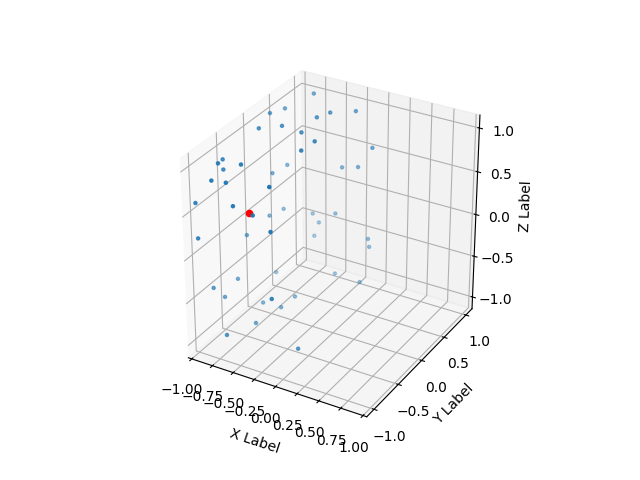

In [197]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
decimate=1000
xs = res[0, ::decimate]
ys = res[1, ::decimate]
zs = res[2, ::decimate]
ax.scatter(xs, ys, zs, marker='.')
ax.scatter(*u_cubized, marker='o', color=("red"))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim([-1, 1])
ax.set_aspect("equal")

plt.show()

### 4. Cube UV to pixels

In [37]:
# Obtain face index for each coordinate
face_index = cubemap_instance.cube_face_list(res)
u_face_index = cubemap_instance.cube_face_list(u_cubized)
print(np.unique(face_index,return_counts=True))
print(u_face_index)

(array([1, 2, 3, 4, 5], dtype=int64), array([16636,  8362,  8411,  8327,  8264], dtype=int64))
[1]


In [23]:
# PixelID for each coordinate from top left (numpy row col system)
# array(2, n)
PixelID = np.zeros((2,len(face_index)))

PixelID[:,face_index==0] = ((np.array([ -res[2,face_index==0], -res[1,face_index==0]])+1)/2)
PixelID[:,face_index==1] = ((np.array([ -res[2,face_index==1],  res[1,face_index==1]])+1)/2)
PixelID[:,face_index==2] = ((np.array([ -res[2,face_index==2],  res[0,face_index==2]])+1)/2)
PixelID[:,face_index==3] = ((np.array([ -res[2,face_index==3], -res[0,face_index==3]])+1)/2)
PixelID[:,face_index==4] = ((np.array([  res[1,face_index==4],  res[0,face_index==4]])+1)/2)
PixelID[:,face_index==5] = ((np.array([ -res[1,face_index==5],  res[0,face_index==5]])+1)/2)

PixelID=(PixelID * cubemap_instance.resolution[0]).astype(np.int32) # image resolution size

In [48]:
# vector u pixel:
u_PixelID = np.array([[0],[0]],dtype=np.float32)
u_PixelID[:,u_face_index==0] = ((np.array([ -u_cubized[2,u_face_index==0], -u_cubized[1,u_face_index==0]])+1)/2)
u_PixelID[:,u_face_index==1] = ((np.array([ -u_cubized[2,u_face_index==1],  u_cubized[1,u_face_index==1]])+1)/2)
u_PixelID[:,u_face_index==2] = ((np.array([ -u_cubized[2,u_face_index==2],  u_cubized[0,u_face_index==2]])+1)/2)
u_PixelID[:,u_face_index==3] = ((np.array([ -u_cubized[2,u_face_index==3], -u_cubized[0,u_face_index==3]])+1)/2)
u_PixelID[:,u_face_index==4] = ((np.array([  u_cubized[1,u_face_index==4],  u_cubized[0,u_face_index==4]])+1)/2)
u_PixelID[:,u_face_index==5] = ((np.array([ -u_cubized[1,u_face_index==5],  u_cubized[0,u_face_index==5]])+1)/2)

u_PixelID=(u_PixelID * cubemap_instance.resolution[0]).astype(np.int32) # image resolution size

In [24]:
# Get a list of all colors array(3, n)
Colors = np.zeros((3,len(face_index)))
for i in range(6):
    Colors[:,face_index==i] =  cubemap_instance.cube_map[cubemap_instance.id_tag[i]][PixelID[0,face_index==i],PixelID[1,face_index==i]].T

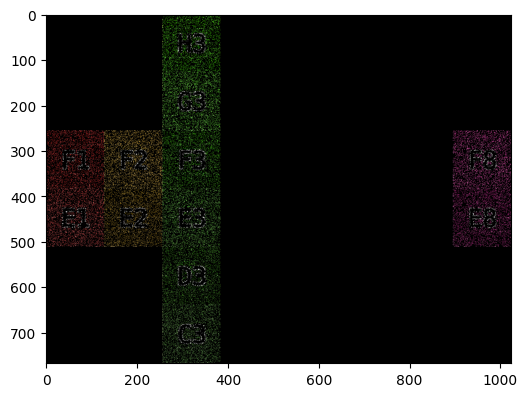

In [25]:
#  For testing propouses we create new images with the pixels rendered.
black_img = np.zeros(cubemap_instance.resolution)
img0 = black_img.copy()
img1 = black_img.copy()
img2 = black_img.copy()
img3 = black_img.copy()
img4 = black_img.copy()
img5 = black_img.copy()
images_ = {
    "bottom":img5,
    "top":img4,
    "back":img3,
    "front":img2,
    "left":img1,
    "right":img0,
}
images = {
    5:img5,
    4:img4,
    3:img3,
    2:img2,
    1:img1,
    0:img0,
}

# add the rendered pixels to the black image
for i in range(6):
    images[i][  PixelID[0,face_index==i], PixelID[1,face_index==i]  ] =  Colors[:,face_index==i].T

cubemap_instance.plot(images_)

### 5. Radiance of a point
At this point we have:
- u vector (direction)
- u pixel coordinate
- u face index
- list of vectors on a cube = np.array(3,n)
- list of faces index of each vector = np.array(n)
- list of pixel position based on the uv = np.array(2,n)
- list of colors for each vector = np.array(3,n)

Now we require additional values to calculate the diffuse light of each points:
- np.dot(u, random_vectors) = np.array(n)

In [55]:
dot_product_vectors = np.dot(u_cubized.T,res)
dot_product_vectors.T

array([[0.03466227],
       [1.        ],
       [0.97268379],
       ...,
       [0.64106726],
       [0.78513167],
       [0.19148356]])

In [117]:
# 1. obtener el pixel sobre el que vamos a trabajar
face=0
pixel=np.array((20,20))

# 2. pass it to uv (-1,1)
u,v = (pixel/cubemap_instance.resolution[0])*2-1
# modify orientation
x= 1
y=-v
z=-u
u = np.array([x,y,z])
u=u/np.linalg.norm(u)
# since this is the positive x face we need to create the vector that points on the x positive direction

In [194]:
def pixel_to_vector(x,y,f):
    pixel=np.array((x,y))
    u,v = (pixel/cubemap_instance.resolution[0])*2-1
    if f == 0:
        x=  1
        y= -v
        z= -u
    elif f == 1:
        x= -1
        y=  v
        z= -u
    elif f == 2:
        x=  v
        y=  1
        z= -u
    elif f == 3:
        x= -v
        y= -1
        z= -u
    elif f == 4:
        x=  v
        y=  u
        z=  1
    else:
        x= v
        y= -u
        z= -1
    u = np.array([x,y,z])
    u=u/np.linalg.norm(u)
    return u

u = pixel_to_vector(0,256,3)

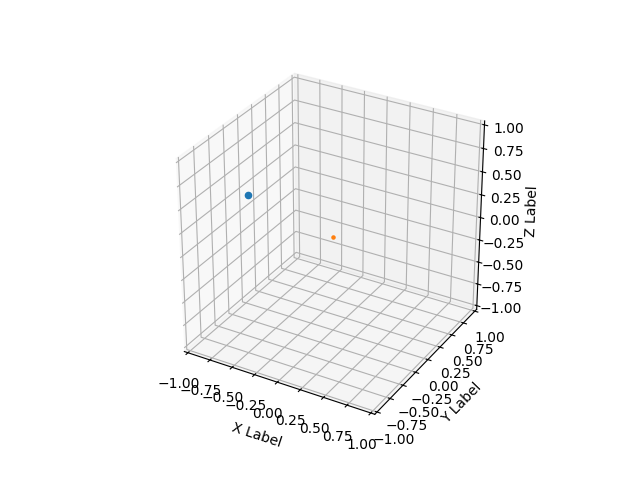

In [195]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*u, marker='o')
ax.scatter(0, 0, 0, marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_aspect("equal")

plt.show()

### 5. Bucle of Diffuse map

In [257]:
prev_prg=""
sample = 100
angle = 10
for face in range(6):
    test_img = np.zeros((cubemap_instance.resolution), dtype=np.float32)
    for row in range(cubemap_instance.resolution[0]):
        for col in range(cubemap_instance.resolution[1]):
            try:
                
                # generate u vector (alredy cubized)
                u = pixel_to_vector(row,col,face)
                original_color = cubemap_instance.cube_map[cubemap_instance.id_tag[i]][row,col].T
                
                # generate neigbour vectors
                R_rotated = cubemap_instance.generate_similar_vectors(u, sample, angle)

                # project vectors on cube
                # u_cubized = cubize_points_fast(np.array([u]).T)
                R_cubized = cubize_points_fast(R_rotated.copy())
                
                # obtain cube UVs from vectors 
                cubemap_instance.prepare_face_index(R_cubized)
                PixelID = cubemap_instance.cubized_vector_to_pixel(R_cubized)
                
                # get colors of the reflacted vectors
                Colors = cubemap_instance.pixel_to_color(PixelID)
                dot_product_vectors = np.dot(u.T,R_cubized)
                
                # ponderate colors
                total_weight = np.sum(dot_product_vectors) + 1
                mean_color = np.sum(Colors*dot_product_vectors, axis=1) + original_color
                
                mean_color/=total_weight
                
                test_img[row,col]=mean_color
            except:
                print(row,col)
        prg = "progress {:.2f}".format(((cubemap_instance.resolution[0]*face + row) / (6*cubemap_instance.resolution[0])))
        if prev_prg!=prg:
            print(prg)
            prev_prg=prg
    cubemap_instance.cube_map_diffuse[cubemap_instance.id_tag[face]] = test_img.copy()

progress 0.00
progress 0.01
progress 0.02
progress 0.03
progress 0.04
progress 0.05
progress 0.06
progress 0.07
progress 0.08
progress 0.09
progress 0.10
progress 0.11
progress 0.12
progress 0.13
progress 0.14
progress 0.15
progress 0.16
progress 0.17
progress 0.18
progress 0.19
progress 0.20
progress 0.21
progress 0.22
progress 0.23
progress 0.24
progress 0.25
progress 0.26
progress 0.27
progress 0.28
progress 0.29
progress 0.30
progress 0.31
progress 0.32
progress 0.33
progress 0.34
progress 0.35
progress 0.36
progress 0.37
progress 0.38
progress 0.39
progress 0.40
progress 0.41
progress 0.42
progress 0.43
progress 0.44
progress 0.45
progress 0.46
progress 0.47
progress 0.48
progress 0.49
progress 0.50
progress 0.51
progress 0.52
progress 0.53
progress 0.54
progress 0.55
progress 0.56
progress 0.57


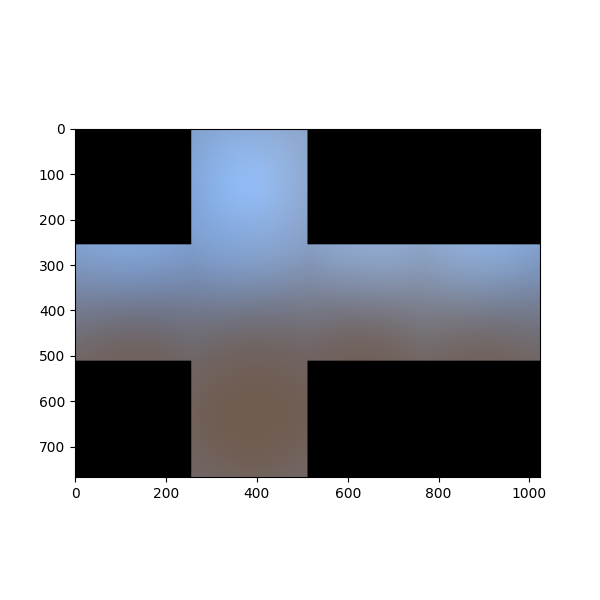

In [251]:
cubemap_instance.plot(cubemap_instance.cube_map_diffuse)

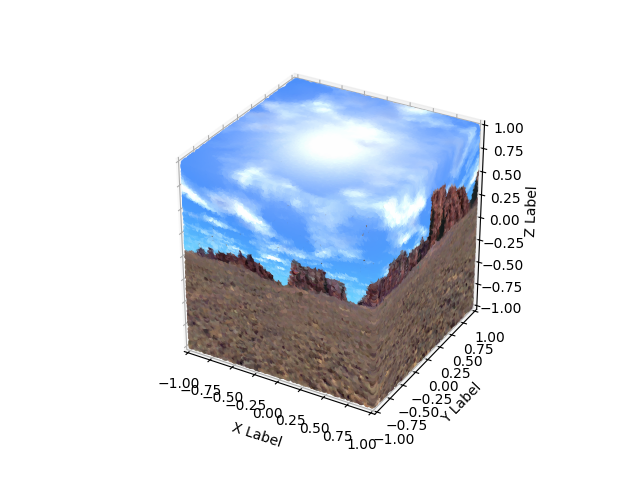

In [256]:
row=128
col=128
face=0
# generate u vector (alredy cubized)
u = pixel_to_vector(row,col,face)
original_color = cubemap_instance.cube_map[cubemap_instance.id_tag[i]][row,col].T

# generate neigbour vectors
R_rotated = cubemap_instance.generate_similar_vectors(u, 100000, 180)

# project vectors on cube
# u_cubized = cubize_points_fast(np.array([u]).T)
R_cubized = cubize_points_fast(R_rotated.copy())
# cubemap_instance.plot_normal(R_rotated)

# obtain cube UVs from vectors 
cubemap_instance.prepare_face_index(R_cubized)
PixelID = cubemap_instance.cubized_vector_to_pixel(R_cubized)

# get colors of the reflacted vectors
Colors = cubemap_instance.pixel_to_color(PixelID)
dot_product_vectors = np.dot(u.T,R_cubized)

# ponderate colors
total_weight = np.sum(dot_product_vectors) + 1
mean_color = np.sum(Colors*dot_product_vectors, axis=1) + original_color

mean_color/=total_weight

test_img[row,col]=mean_color

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
decimate=1
xs = R_cubized[0, ::decimate]
ys = R_cubized[1, ::decimate]
zs = R_cubized[2, ::decimate]
ax.scatter(xs, ys, zs, marker='.', c=Colors.T)
ax.scatter(*u, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_aspect("equal")

plt.show()

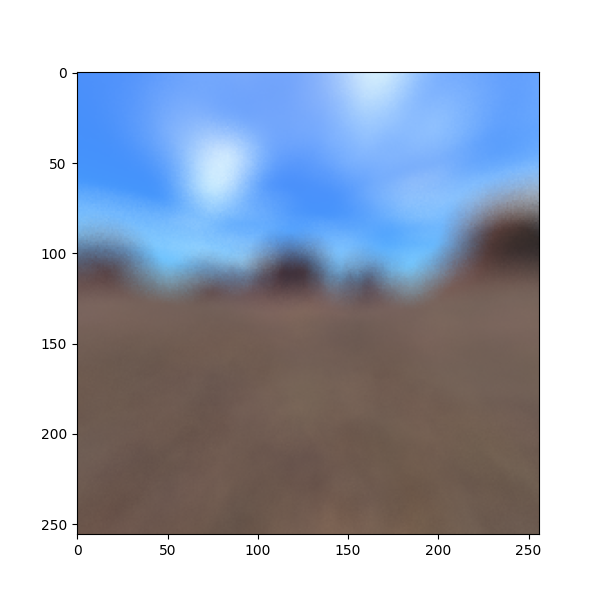

In [238]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(test_img)
plt.show()

### Saving the images

In [254]:
import os
subfolder =  f"./test_images_out/{angle}_{sample}"
path =

if not os.path.exists(subfolder):
    os.makedirs(subfolder)

for i in range(6):
    name=cubemap_instance.id_tag[i]
    plt.imsave(f'{path}/{name}.png', cubemap_instance.cube_map_diffuse[name])

In [ ]:
direction = np.array([0,0.5,.5])
quantity = 200

# Normal list format:
# [
# [x0,x1,x2...],
# [y0,y1,y2...],
# [z0,z1,z2...]
# ]
normal_list=cubemap_instance._random_radiance_normal(direction,quantity)
cubemap_instance.plot_normal(normal_list,direction*2)

In [ ]:

normal_list=cubemap_instance.generate_similar_vectors(np.array([0,0,1]),quantity,45)
cubemap_instance.plot_normal(normal_list.T*1.2,np.array([0,0,1]))

## Cube projection
This is the code to obtain the projected cube based on normals.

For this example, the code will run over all posible pixels and faces to get the projected color for each normal

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
w,h,c=cubemap_instance.resolution
img = np.zeros((w*3,h*4,3))

for f in range(6):
    for x in range(cubemap_instance.resolution[0]): # fila
        for y in range(cubemap_instance.resolution[1]): # columna
            u = cubemap_instance._pixel_to_normal(x,y,f)
            x,y,f = cubemap_instance._normal_to_pixel(u)
            if f==0:
                # img[y+h,x+w*2-2]=cubemap_instance._get_color(x,y,f)
                img[x+h,y+w*2-2]=cubemap_instance._get_color(x,y,f)
            if f==1:
                # img[y+h,x]=cubemap_instance._get_color(x,y,f)
                img[x+h,y]=cubemap_instance._get_color(x,y,f)
            if f==2:
                # img[y+h,x+w*3-3]=cubemap_instance._get_color(x,y,f)
                img[x+h,y+w*3-3]=cubemap_instance._get_color(x,y,f)
            if f==3:
                # img[y+h,x+w-1]=cubemap_instance._get_color(x,y,f)
                img[x+h,y+w-1]=cubemap_instance._get_color(x,y,f)
            if f==4:
                # img[y,x+w-1]=cubemap_instance._get_color(x,y,f)
                img[x,y+w-1]=cubemap_instance._get_color(x,y,f)
            if f==5:
                # img[y+2*h-2,x+w-1]=cubemap_instance._get_color(x,y,f)
                img[x+2*h-2,y+w-1]=cubemap_instance._get_color(x,y,f)

ax.imshow(img)
plt.show()


Calculating diffuse map

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
w,h,c=cubemap_instance.resolution
img = np.zeros((w*3-2,h*4-3,3))
prev_prg = ""

for f in range(6):
    for x in range(cubemap_instance.resolution[0]):
        for y in range(cubemap_instance.resolution[1]):
            
            # Original color
            original_color = cubemap_instance._get_color(x,y,f).copy()
            # get normal to calculate hemisphere
            n = cubemap_instance._pixel_to_normal(x,y,f)
            n /= np.linalg.norm(n)
            # hemisphere
            normal_list = cubemap_instance._random_radiance_normal(n,1)
            # influencia en el nuevo color?
            for reflacted in normal_list.T:
                # reflacted_pix = cubemap_instance._normal_to_pixel(n)
                reflacted = reflacted/np.linalg.norm(reflacted)
                reflacted_pix = cubemap_instance._normal_to_pixel(reflacted)
                reflacted_col = cubemap_instance._get_color(reflacted_pix[0],reflacted_pix[1],reflacted_pix[2]).copy()
                dot_product = np.dot(n/np.linalg.norm(n), reflacted/np.linalg.norm(reflacted))
                if dot_product<0: 
                    print(dot_product)
                original_color += reflacted_col*dot_product
                original_color/=2

            # Storing on image
            if f==0:
                img[x+h,y+w*2-2]=original_color
            if f==1:
                img[x+h,y]=original_color
            if f==2:
                img[x+h,y+w*3-3]=original_color
            if f==3:
                img[x+h,y+w-1]=original_color
            if f==4:
                img[x,y+w-1]=original_color
            if f==5:
                img[x+2*h-2,y+w-1]=original_color
        
        prg = "progress {:.2f}".format(((cubemap_instance.resolution[0]*f + x) / (6*cubemap_instance.resolution[0])))
        if prev_prg!=prg:
            print(prg)
            prev_prg=prg

ax.imshow(img)
plt.show()

In [ ]:

def generate_random_points(num_points):
    """
    Generate random 3D points uniformly distributed on a unit sphere.
    """
    phi = np.random.uniform(0, np.pi, num_points)
    theta = np.random.uniform(0, 2*np.pi, num_points)
    
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    points = np.column_stack((x, y, z))
    return points

def filter_points_within_angle(points, center, angle_deg, num_points):
    """
    Filter points that fall within a circular area on the sphere and return exactly num_points.
    """
    center = np.array(center)
    angle_rad = np.radians(angle_deg)
    filtered_points = []
    
    for point in points:
        angle_between = np.arccos(np.dot(center, point))
        if angle_between <= angle_rad:
            filtered_points.append(point)
            if len(filtered_points) == num_points:
                return np.array(filtered_points)
    
    return np.array(filtered_points)

# Generate random points on the sphere
num_points = 8000000  # Increase the number of initial points
random_points = generate_random_points(num_points)

# Specify the number of points needed within the circular area
n = 50

# Specify the center and angle of the circular area
center = cubemap_instance._pixel_to_normal(0,0,3)
angle_deg = 15

# Filter points within the circular area until we have exactly n points
points_within_angle = filter_points_within_angle(random_points, center, angle_deg, n)
print(len(points_within_angle))

In [ ]:

cubemap_instance.plot_normal(points_within_angle.T*1.2,center)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
w,h,c=cubemap_instance.resolution
img = np.zeros((w*3-2,h*4-3,3))
prev_prg = ""

f=0
for f in range(6) :
    for x in range(cubemap_instance.resolution[0]):
        for y in range(cubemap_instance.resolution[1]):
            
            # Original color
            original_color = cubemap_instance._get_color(x,y,f).copy()
            # get normal to calculate hemisphere
            n = cubemap_instance._pixel_to_normal(x,y,f)
            n /= np.linalg.norm(n)
            # hemisphere
            random_points = generate_random_points(5000)
            normal_list = filter_points_within_angle(random_points, n, 10, 20)

            # influencia en el nuevo color?
            total_weight=1
            for reflacted in normal_list:
                # reflacted_pix = cubemap_instance._normal_to_pixel(n)
                reflacted = reflacted/np.linalg.norm(reflacted)
                reflacted_pix = cubemap_instance._normal_to_pixel(reflacted)
                reflacted_col = cubemap_instance._get_color(reflacted_pix[0],reflacted_pix[1],reflacted_pix[2]).copy()
                dot_product = np.dot(n/np.linalg.norm(n), reflacted/np.linalg.norm(reflacted))
                total_weight+=dot_product
                if dot_product<0: 
                    print(dot_product)
                original_color += reflacted_col*dot_product
            original_color/=total_weight

            # Storing on image
            if f==0:
                img[x+h,y+w*2-2]=original_color
            elif f==1:
                img[x+h,y]=original_color
            elif f==2:
                img[x+h,y+w*3-3]=original_color
            elif f==3:
                img[x+h,y+w-1]=original_color
            elif f==4:
                img[x,y+w-1]=original_color
            elif f==5:
                img[x+2*h-2,y+w-1]=original_color
        
        prg = "progress {:.2f}".format(((cubemap_instance.resolution[0]*f + x) / (6*cubemap_instance.resolution[0])))
        if prev_prg!=prg:
            print(prg)
            prev_prg=prg

ax.imshow(img)
plt.show()